# Vents Group - Version 1
OOI Data Labs Workshop - March 2019

A possible interactive would include timeseries of 3D-Temp and Earthquakes that allows students to see the larger context, while viewing video stills from 2 different scenes.

Potetial timeframe: June 2018-January 2019 (or to present)

In [0]:
# Notebook Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Earthquake Data - First Attempt
Lets try the automatic approach first.

In [2]:
# Load in Earthquake data
eq_url = 'http://axial.ocean.washington.edu/hypo71.dat'
data = pd.read_fwf(eq_url)
data.head()

,yyyymmdd,HHMMSSS.SS,Lat(D M),Lon(D M),Depth,MW NWR,GAP,DMIN,RMS,ERH,ERZ,ID,PMom,SMom
0,20150122,0000 27.54,45 56.81,129 59.92,0.55,-0.31 7,206,1.2,0.03,0.8,0.4,20830,3.800000e+17,3.900000e+17
1,20150122,0008 58.89,45 56.96,129 59.70,0.00,0.02 10,149,1.2,0.09,0.2,0.2,20831,1.900000e+18,7.800000e+17
2,20150122,0202 41.04,45 56.47,130 0.89,0.67,-0.03 12,200,0.8,0.03,0.9,0.7,20836,1.400000e+18,7.200000e+17
3,20150122,0219 56.90,45 54.93,129 57.59,1.60,0.26 7,325,1.8,0.06,1.4,2.5,20837,3.300000e+18,2.200000e+18
4,20150122,0236 7.08,45 56.80,129 59.71,0.51,-0.15 8,160,1.2,0.06,0.5,0.2,20840,6.700000e+17,6.800000e+17


This looks pretty good, but we need to reformat several columns.

In [3]:
# Convert time
data['DateTime'] = pd.to_datetime(data['yyyymmdd'].astype(str) + ' ' + data['HHMMSSS.SS'].astype(str), format='%Y%m%d %H%M %S.%f')

# Convert Lat and Lon
def dm2dd(s):
  degrees, minutes, = s.split()
  dd = float(degrees) + float(minutes)/60
  return dd

data['Latitude'] = data['Lat(D M)'].apply(dm2dd)
data['Longitude'] = -data['Lon(D M)'].apply(dm2dd) #Add negative for West

# Split the MW and NWR columns
new = data['MW NWR'].str.split(' ', n=1, expand=True)
data['MW'] = new[0].astype(float)
data['NWR'] = new[1].astype(float)
data.drop(columns=['yyyymmdd','HHMMSSS.SS','Lat(D M)','Lon(D M)','MW NWR'], inplace=True)

data.head()

,Depth,GAP,DMIN,RMS,ERH,ERZ,ID,PMom,SMom,DateTime,Latitude,Longitude,MW,NWR
0,0.55,206,1.2,0.03,0.8,0.4,20830,3.800000e+17,3.900000e+17,2015-01-22 00:00:27.540,45.946833,-129.998667,-0.31,7.0
1,0.00,149,1.2,0.09,0.2,0.2,20831,1.900000e+18,7.800000e+17,2015-01-22 00:08:58.890,45.949333,-129.995000,0.02,10.0
2,0.67,200,0.8,0.03,0.9,0.7,20836,1.400000e+18,7.200000e+17,2015-01-22 02:02:41.040,45.941167,-130.014833,-0.03,12.0
3,1.60,325,1.8,0.06,1.4,2.5,20837,3.300000e+18,2.200000e+18,2015-01-22 02:19:56.900,45.915500,-129.959833,0.26,7.0
4,0.51,160,1.2,0.06,0.5,0.2,20840,6.700000e+17,6.800000e+17,2015-01-22 02:36:07.080,45.946667,-129.995167,-0.15,8.0


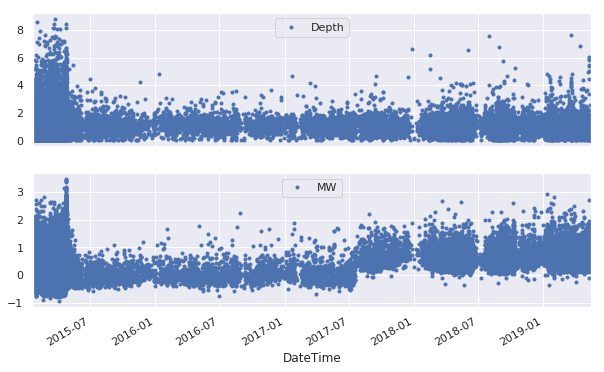

In [4]:
# Quickplot
fig, (ax1,ax2) = plt.subplots(2,1, sharex=True, figsize=(10,6))
data.plot(ax=ax1, x='DateTime',y='Depth',marker='.',linestyle='');
data.plot(ax=ax2, x='DateTime',y='MW',marker='.',linestyle='');

## Earthquake Data - Second Attempt
This time, we'll explicitely extract just the columns we need.  However, we'll still need to do some conversions, so this doesn't save us much code, but it does save a few lines.

In [5]:
data = pd.read_fwf(eq_url, colspecs=[(0,19),(20,28),(29,38),(40,45),(47,52)])

# Convert time
data.index = pd.to_datetime(data['yyyymmdd HHMMSSS.SS'].astype(str), format='%Y%m%d %H%M %S.%f')
data.index.name = 'DateTime'

data['Latitude'] = data['Lat(D M)'].apply(dm2dd)
data['Longitude'] = -data['Lon(D M)'].apply(dm2dd) #Add negative for West

data.tail()

,yyyymmdd HHMMSSS.SS,Lat(D M),Lon(D M),Depth,MW,Latitude,Longitude
DateTime,,,,,,,
2019-05-15 02:55:56.000,20190515 0255 56.00,45 49.69,130 4.06,1.00,1.55,45.828167,-130.067667
2019-05-15 04:05:07.850,20190515 0405 7.85,45 55.87,129 59.61,1.78,0.51,45.931167,-129.993500
2019-05-15 06:22:26.850,20190515 0622 26.85,45 55.44,129 58.46,1.28,1.00,45.924000,-129.974333
2019-05-15 06:54:58.490,20190515 0654 58.49,45 55.51,129 58.36,0.91,0.54,45.925167,-129.972667
2019-05-15 14:01:39.560,20190515 1401 39.56,45 56.57,130 1.19,0.76,0.56,45.942833,-130.019833


## Simple Earthqake map

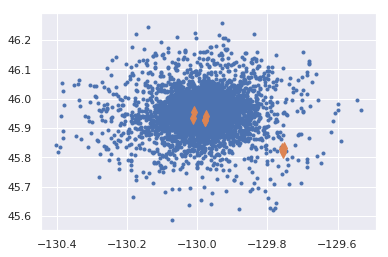

In [6]:
# Let's plot the quakes
plt.plot(data.Longitude,data.Latitude,marker='.',linestyle='');
xlim = plt.xlim()
ylim = plt.ylim()

# Add the OOI Sites
sites = pd.read_csv('https://github.com/seagrinch/data-team-python/raw/master/infrastructure/sites.csv')
plt.plot(sites.longitude,sites.latitude,'d',markersize=8)

# Reset the limits
plt.xlim(xlim)
plt.ylim(ylim);

## Hexbin map
First, let's create a hexbin map the regular way, but we'll set the aspect ratio of the plot so it's close to a Mercator projection.

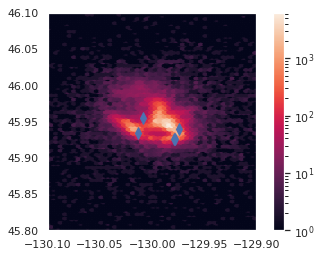

In [7]:
fig, ax = plt.subplots()
plt.hexbin(data.Longitude,data.Latitude,gridsize=200,bins='log')
plt.colorbar();
plt.plot(sites.longitude,sites.latitude,'d',markersize=8)
plt.xlim(-130.1,-129.9)
plt.ylim(45.8,46.1);
aspect_ratio = np.cos(np.mean(plt.ylim())*np.pi/180)
ax.set_aspect(aspect_ratio);

We can also get a little fancier and also use cartopy so we get the proper map projection.

In [0]:
!apt-get -qq install python-cartopy python3-cartopy
import cartopy.crs as ccrs

/usr/local/lib/python3.6/dist-packages/matplotlib/ticker.py:1879: UserWarning: Steps argument should be a sequence of numbers
increasing from 1 to 10, inclusive. Behavior with
values outside this range is undefined, and will
raise a ValueError in future versions of mpl.
  warnings.warn('Steps argument should be a sequence of numbers\n'


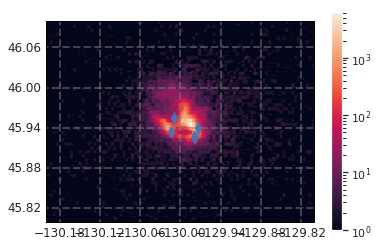

In [9]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-130.2,-129.8,45.8,46.1], crs=ccrs.PlateCarree())
plt.hexbin(data.Longitude,data.Latitude,gridsize=200,bins='log',transform=ccrs.Geodetic())
plt.colorbar();
plt.plot(sites.longitude,sites.latitude,'d',markersize=8)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

## Daily Earthquake Averages

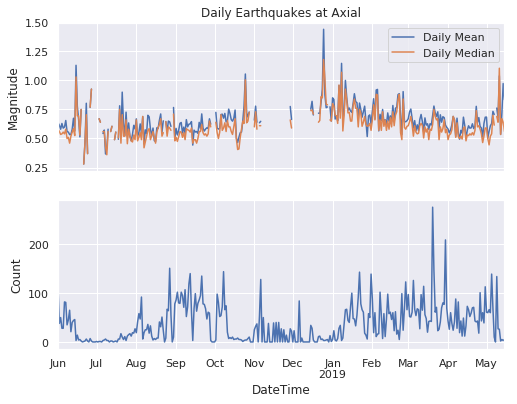

In [10]:
data_sub = data.loc['2018-6-1':'2019-6-1']

fig,(ax1,ax2) = plt.subplots(2,1,figsize=(8,6),sharex=True,sharey=False)
# data_sub['MW'].resample('1H').mean().plot(ax=ax1,label='Hourly Mean',marker='.',markersize=1,linestyle='');
data_sub['MW'].resample('D').mean().plot(ax=ax1,label='Daily Mean');
data_sub['MW'].resample('D').median().plot(ax=ax1,label='Daily Median');
ax1.legend();

data_sub['MW'].resample('D').count().plot(ax=ax2,label='Count');

ax1.set_ylabel('Magnitude')
ax2.set_ylabel('Count');
ax1.set_title('Daily Earthquakes at Axial');

## TMPSF Data
Next will request and process data from the Thermistor array at Axial Seamount.

### Request Data

In [11]:
# More setup
import requests
import os
import re
import xarray as xr
! pip install netcdf4==1.5.0

In [0]:
def request_data(reference_designator,method,stream,start_date,end_date):
  site = reference_designator[:8]
  node = reference_designator[9:14]
  instrument = reference_designator[15:]
  
  # Create the request URL
  api_base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv'
  data_request_url ='/'.join((api_base_url,site,node,instrument,method,stream))

  # All of the following are optional, but you should specify a date range
  params = {
    'beginDT':start_date,
    'endDT':end_date,
    'format':'application/netcdf',
    'include_provenance':'true',
    'include_annotations':'true'
  }

  # Make the data request
  r = requests.get(data_request_url, params=params, auth=(API_USERNAME, API_TOKEN))
  data = r.json()
  
  # Return just the THREDDS URL
  return data['allURLs'][0] 

In [0]:
API_USERNAME = ''
API_TOKEN = ''

The next line is used to request a dataset from the OOI Data Portal.  

**Note, this line only needs to be run once** and then I recommend commenting it out so you don't accidentlally rerun it again. When you run it, simply save the outputted URL in the next line of code, so you can then grab the data.

Of course, if you wish to grab a different time range, including more recent data, you will need to rerun the request line.  Also, note that it will take a few minutes for new data requests to be processed, so you will not be able to contiue on with the notebook until the data files are ready.


In [0]:
# Data Request
# request_data('RS03ASHS-MJ03B-07-TMPSFA301','streamed','tmpsf_sample',
#              '2018-06-01T00:00:00.000Z','2019-06-01T00:00:00.000Z')


### Load and Process Data

In [0]:
# This is the output URL from the request_data line
data_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20190515T024738-RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample/catalog.html'

In [0]:
def get_data(url,bad_inst=''):
  tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
  datasets = requests.get(url).text
  urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
  x = re.findall(r'(ooi/.*?.nc)', datasets)
  for i in x:
    if i.endswith('.nc') == False:
      x.remove(i)
  for i in x:
    try:
      float(i[-4])
    except:
      x.remove(i)
  datasets = [os.path.join(tds_url, i) for i in x]
  
  # Remove extraneous files if necessary
  selected_datasets = []
  for d in datasets:
    if (bad_inst) and bad_inst in d:
      pass
    else:
      selected_datasets.append(d)
#   print(selected_datasets)
  
  # Load in dataset
  ds = xr.open_mfdataset(selected_datasets)
  ds = ds.swap_dims({'obs': 'time'}) # Swap the primary dimension
  ds = ds.chunk({'time': 1000}) # Used for optimization
  ds = ds.sortby('time') # Data from different deployments can overlap so we want to sort all data by time stamp.
  return ds

In [0]:
# Grab the data
tmpsf_data = get_data(data_url)

Note, for plotting, we will use the 3 center thermistors (1=bottom, 14=mid, and 15=top), as defined in the [TMPSF DPS](https://oceanobservatories.org/instrument-class/tmpsf/).  You can easily plot others as well.

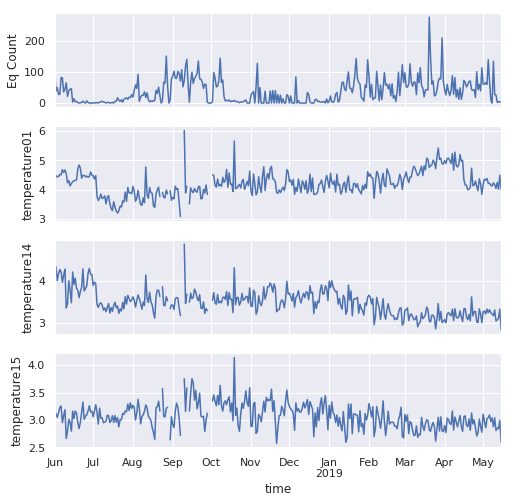

In [17]:
# Let's make a plot
fig,ax = plt.subplots(4,1,figsize=(8,8),sharex=True)

# And the Earthquake dataset at the top
data.loc['2018-6-1':'2019-6-1']['MW'].resample('D').count().plot(ax=ax[0]);
ax[0].set_ylabel('Eq Count')

# Now add some selected thermistors
thermistors = [1,14,15]
spa = 1 # Subplot axes
for thermistor in thermistors:
  # Due to a quirk, I had to add .to_dataframe() to the next line so both variables are DataFrames
  tmpsf_data["temperature%02d" % (thermistor)].resample(time='1D').mean().to_dataframe().plot(ax=ax[spa],legend=False)
  ax[spa].set_ylabel("temperature%02d" % (thermistor))
  spa = spa+1
  

### Export the dataset
The next few lines will concatenate the earthquake dataset along with a few selected thermistors so we can export the full (daily averaged) dataset as a CSV file for use in Excel or an interactive widget.

In [0]:
# First will create the averages as xarrays
eq1 = data.loc['2018-6-1':'2019-6-1']['MW'].resample('D').count()
eq1.index.name = 'time'
eq1.name = 'Eq Count'
eq1 = eq1.to_xarray()

eq2 = data.loc['2018-6-1':'2019-6-1']['MW'].resample('D').mean()
eq2.index.name = 'time'
eq2.name = 'Eq Magnitude'
eq2 = eq2.to_xarray()

a = tmpsf_data["temperature01"].resample(time='1D').mean()
b = tmpsf_data["temperature14"].resample(time='1D').mean()
c = tmpsf_data["temperature15"].resample(time='1D').mean()

In [31]:
# Now we'll merge the datasets and convert to a pandas dataframe
# This could potentially be done the other way around, but I found this order easier.
x = xr.merge([a,b,c,eq1,eq2]).to_dataframe()

# Print the first few rows
x.head()

,temperature01,temperature14,temperature15,Eq Count,Eq Magnitude
time,,,,,
2018-06-01,4.253611,4.142796,3.165417,110,0.635364
2018-06-02,4.469778,4.328443,3.117677,38,0.614211
2018-06-03,4.443817,3.995430,3.044819,50,0.579800
2018-06-04,4.439836,4.164629,3.128654,28,0.629286
2018-06-05,4.515790,4.261697,3.230867,28,0.589286


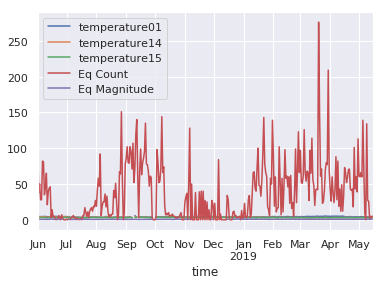

In [32]:
# Quickplot
x.plot();

In [0]:
# Export to CSV
x.to_csv('axial_data.csv')